In [1]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import ns
import history_cmc as hic
import math
import scipy
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import gzip
import sys
import astropy
from astropy import units

import ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc
import conversions



%matplotlib inline

matplotlib.rcParams.update({'font.size': 24})
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun

2.1.2


['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0610.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0615.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0620.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0625.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0630.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0635.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0640.2Dproj.dat.gz']
#t=10303.5

10303.5
#t=10775.1

10775.1
#t=11329

11329
#t=11887.9

11887.9
#t=12596.2

12596.2
#t=13237.7

13237.7
#t=14000.1

14000.1
['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_elson_rv

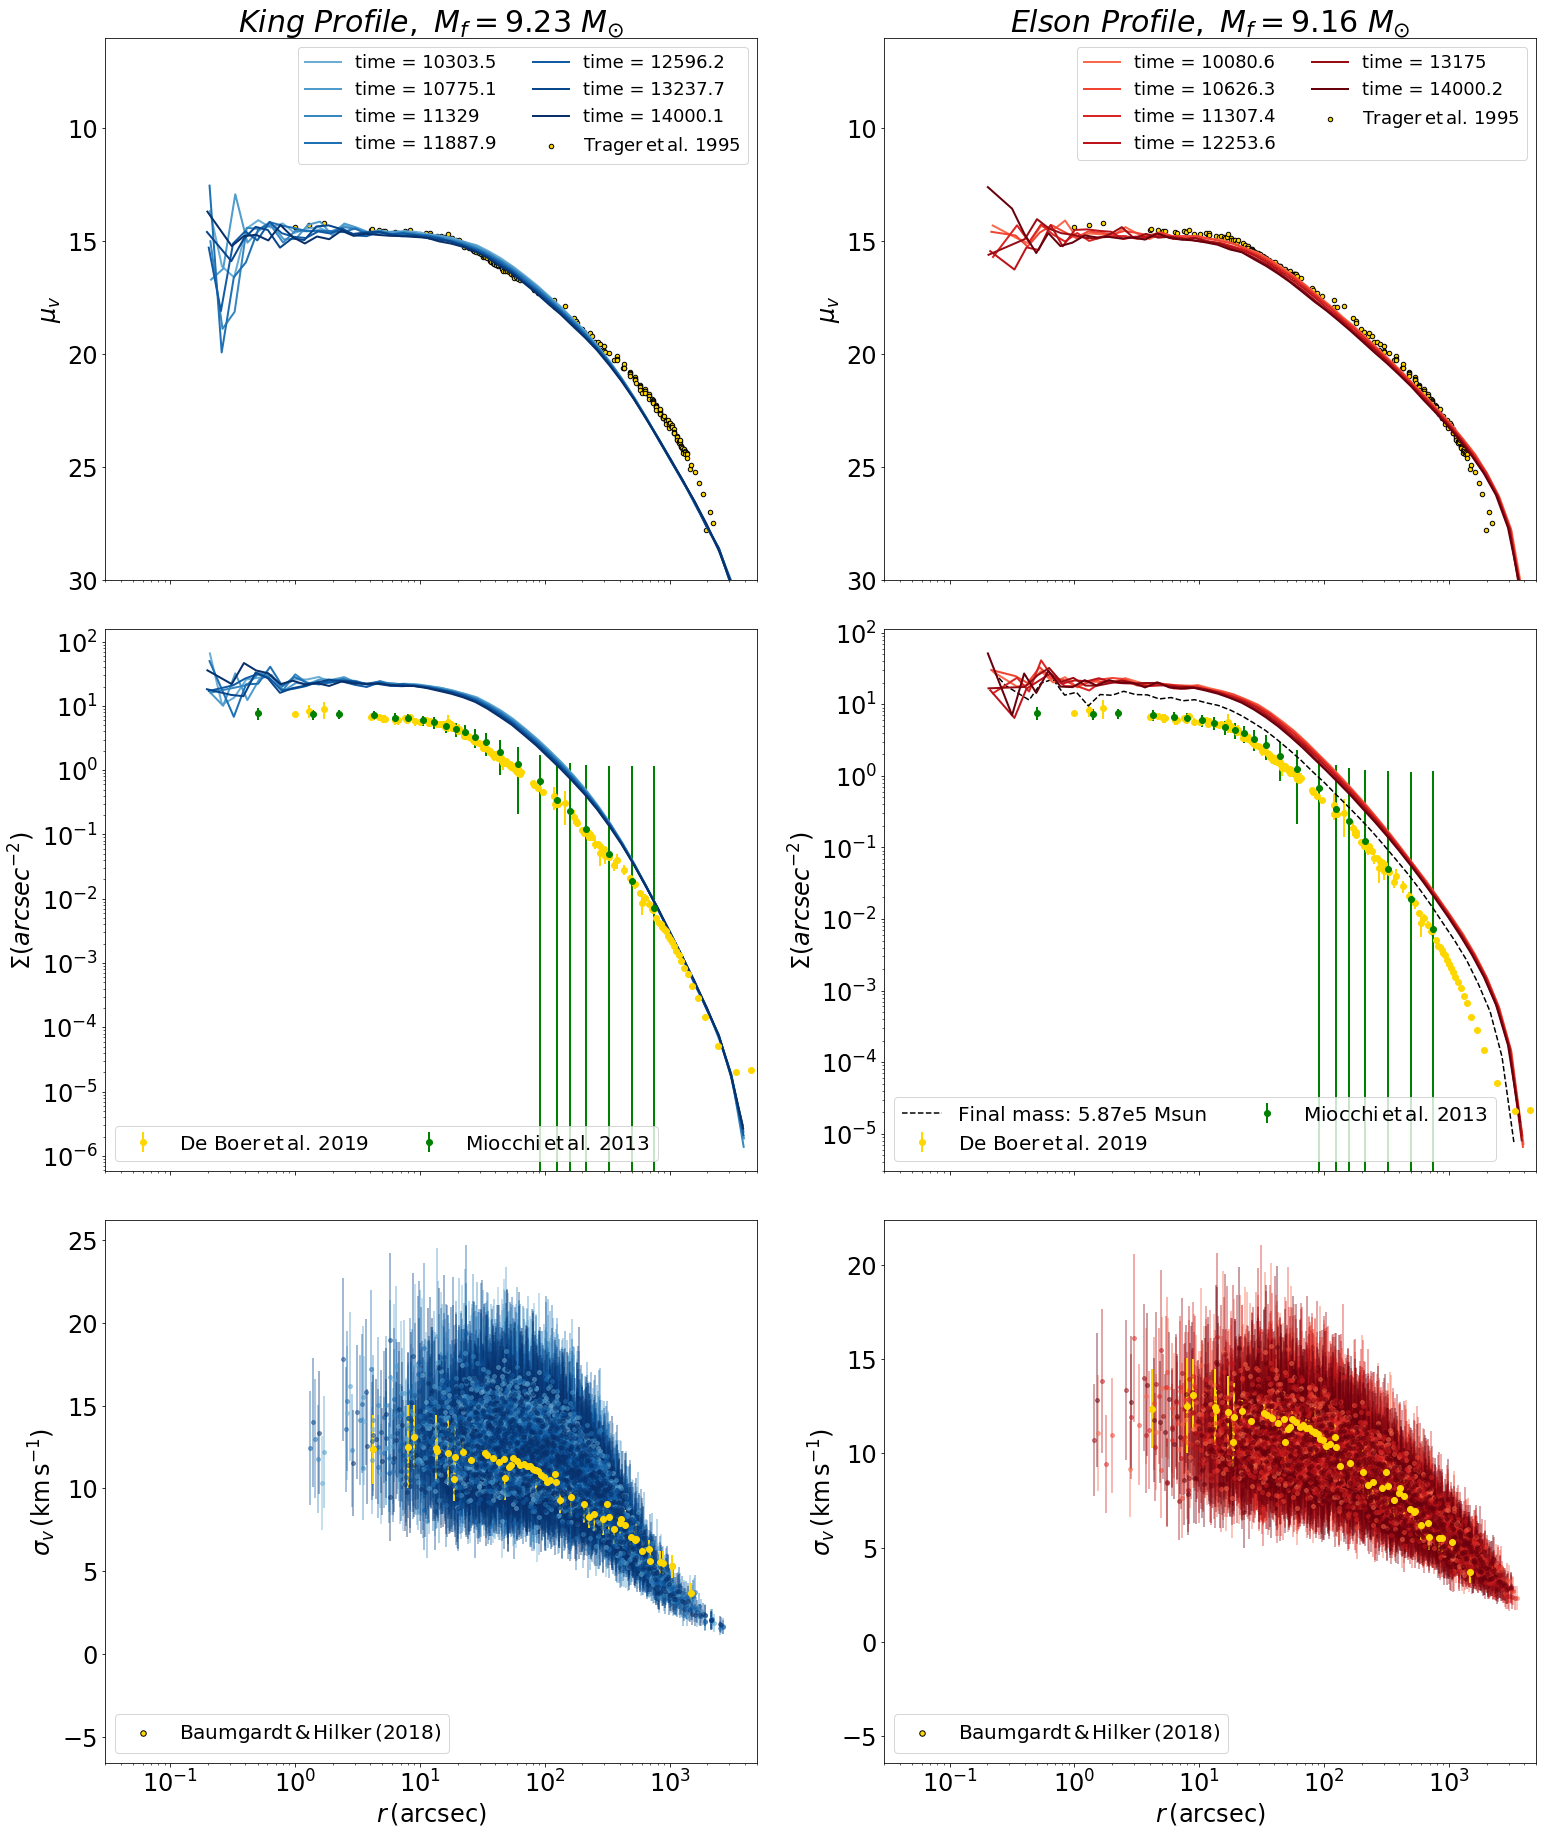

In [5]:
##Model paths: King and Elson
path=['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/', 
      '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_elson_rv4_3e6/']


##Read in observation data
cluster = 'ngc104'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles.dat','r')
linesv = fv.readlines()

R_sun_obs=4.5


flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == cluster:
                R_obs.append(datav[k,1])
                sigma_obs.append(datav[k,2])
                sigma_err_obs_up.append(datav[k,3])
                sigma_err_obs_down.append(datav[k,4])
                flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

datasd_miocchi = np.genfromtxt('makeSBP/miocchi.dat')
arcsec_sd_miocchi = datasd_miocchi[:,0]
sd_obs_miocchi = 10**np.array(datasd_miocchi[:,1])
sd_err_miocchi = 10**np.array(datasd_miocchi[:,2])


datasd_deboer = np.genfromtxt('makeSBP/deboer.dat')
arcsec_sd_deboer = np.array(datasd_deboer[:,0])*60
sd_obs_deboer = np.array(datasd_deboer[:,1])/3600.
sd_err_deboer = np.array(datasd_deboer[:,2])/3600.

data_text=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_elson_rv4_2e6/initial.snap0422.2D_SBPLcut15_NCUT.dat')
arcsec_text=conversions.pc_to_arcsec(data_text[:,1],R_sun_obs)
ND_text = conversions.SD_converter(data_text[:,7], R_sun_obs)

fig, ax=plt.subplots(3, 2, sharex=True, sharey=False, figsize=(22,26))
ax[0][0].set_title(r'$King\ Profile,\ M_f=9.23\ M_{\odot}$', fontsize=30)
ax[0][1].set_title(r'$Elson\ Profile,\ M_f=9.16\ M_{\odot}$', fontsize=30)
ax[1][1].plot(arcsec_text, ND_text, color='black', ls='--', label='Final mass: 5.87e5 Msun')
##Read in model data
for x in range(2):    
    ax[2][x].scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
    ax[2][x].errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
    ax[2][x].scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')

    ax[1][x].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
                      fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
    ax[1][x].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
                      c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')
    
    ax[0][x].scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    
    snap2D = np.sort(glob(path[x]+'initial.snap*.2Dproj.dat.gz'))
    print(snap2D)
    snap2D_Ltot = np.sort(glob(path[x]+'initial.snap*.2D_SBP_NCUT.dat'))
    snap2D_L15 = np.sort(glob(path[x]+'initial.snap*.2D_SBPLcut15_NCUT.dat'))
    snap_giant = np.sort(glob(path[x]+'initial.snap*.vel_dispersion_giants_25.dat'))

    cs = [cm.Blues(np.linspace(0.5, 1, len(snap2D))), cm.Reds(np.linspace(0.5, 1, len(snap2D)))]

    
    for i in range(0, len(snap2D)):
        with gzip.open(snap2D[i], 'r') as f2D:
            first_line=f2D.readline().decode('utf8')
    
        print(first_line)
            
        t_gyr = first_line.strip().split('=')[-1]
        print(t_gyr) 
        data5 = np.genfromtxt(snap2D_L15[i])
        arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
        SB = conversions.SB_converter(data5[:,3])
        SBerr = data5[:,6]/data5[:,5]*SB
        SD = conversions.SD_converter(data5[:,5], R_sun_obs)
        SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
        ND = conversions.SD_converter(data5[:,7], R_sun_obs)
        NDerr = conversions.SD_converter(data5[:,8], R_sun_obs)
        #print(ND)
        

        arcsec_cut = []
        SB_cut = []
        SBerr_cut = []
        arcsec_nd_cut = []
        ND_cut = []
        for k in range(len(SB)):
            if arcsec[k] < 10 and SB[k] > 20:
                Nothing = 0
            else:
                arcsec_cut.append(arcsec[k])
                SB_cut.append(SB[k])
                #SBerr_cut.append(SBerr[k])
            if ND[k]==0:
                continue
            else:
                ND_cut.append(ND[k])
                arcsec_nd_cut.append(arcsec[k])
            

        dataG = np.genfromtxt(snap_giant[i])
        R_model = conversions.pc_to_arcsec(dataG[:,0],R_sun_obs)
        sigma_model = dataG[:,1]
        sigma_err_model = dataG[:,2]

        ax[0][x].plot(arcsec_cut, SB_cut, lw=2, color=cs[x][i])
        ax[1][x].plot(arcsec_nd_cut, ND_cut, lw=2, color=cs[x][i])
        ax[2][x].scatter(R_model, sigma_model,s=15,zorder=2,alpha=0.5, color=cs[x][i])
        ax[2][x].errorbar(R_model,sigma_model,yerr=2*sigma_err_model, fmt='o',markersize=0.01,zorder=1,alpha=0.5, color=cs[x][i])
        #ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
        #ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
        #############################

        #ax1.title(cluster,fontsize=24)
        #ax1.text(300,15,cluster,fontsize=20)
        ax[0][x].plot([10000,10000],[-5,-5], lw=2, label='time = '+str(t_gyr), color=cs[x][i])
        #ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
        ax[0][x].set_xscale('log')
        ax[0][x].set_xlim(0.03,5000)
        ax[0][x].set_ylim(30,6)
        #ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
        ax[0][x].set_ylabel(r'$\mu_v$',fontsize=24)
        ax[0][x].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
        
        ax[1][x].set_xscale('log')
        ax[1][x].set_yscale('log')
        ax[1][x].set_ylabel(r'$\Sigma(arcsec^{-2})$')
        #ax[1][x].set_ylim(0, 35)
        ax[1][x].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 20})

        #ax[2][x].scatter([10000,10000],[-5,-5],lw=2,label='time = '+str(t_gyr), color=cs[i])
        #ax2.scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')
        ax[2][x].set_xscale('log')
        ax[2][x].set_xlim(0.03,5000)
        #ax2.set_ylim(0,10)
        ax[2][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=24)
        ax[2][x].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=24)
        ax[2][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
        
        
        
fig.tight_layout()
plt.savefig('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/sbp_sdp_vel.pdf', dpi=300)

['/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/initial.snap0555.2D_SBPLcut15_NCUT.dat']
#t=11456.2

11456.2


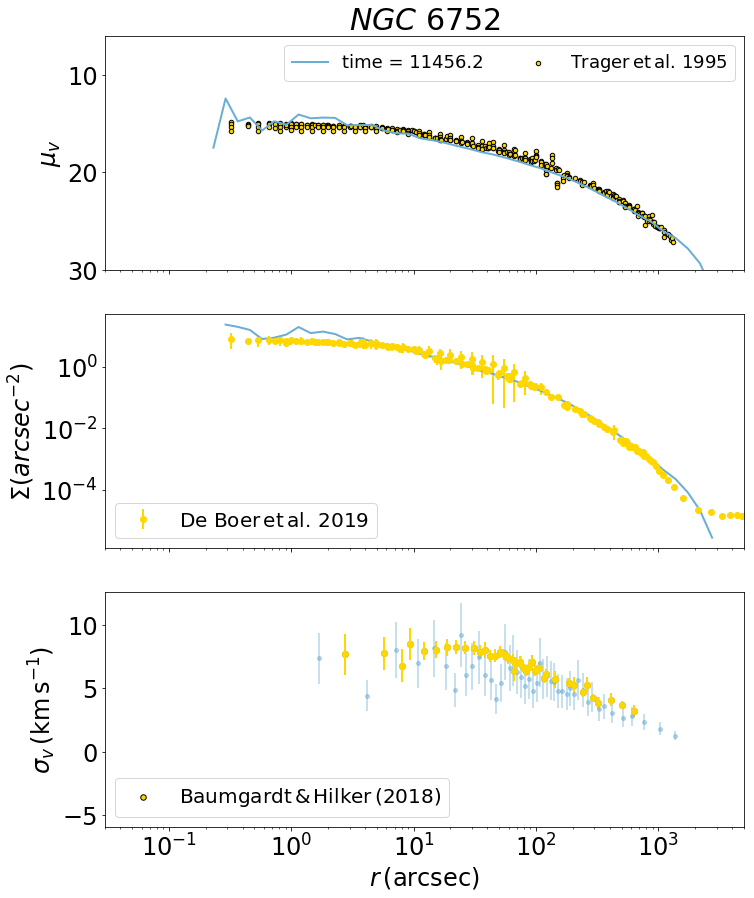

In [3]:
##For single model and snapshot

##Read in observation data
path = '/projects/b1091/CMC_Grid_March2019/rundir/rv0.5/rg8/z0.0002/8e5/'

cluster = 'ngc6752'

R_sun_obs=4.0

ngcno='6752'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles.dat','r')
linesv = fv.readlines()


flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == cluster:
                R_obs.append(datav[k,1])
                sigma_obs.append(datav[k,2])
                sigma_err_obs_up.append(datav[k,3])
                sigma_err_obs_down.append(datav[k,4])
                flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

#datasd_miocchi = np.genfromtxt('makeSBP/miocchi.dat')
#arcsec_sd_miocchi = datasd_miocchi[:,0]
#sd_obs_miocchi = 10**np.array(datasd_miocchi[:,1])
#sd_err_miocchi = 10**np.array(datasd_miocchi[:,2])


datasd_deboer = np.genfromtxt('makeSBP/deboer'+ngcno+'.dat')
arcsec_sd_deboer = np.array(datasd_deboer[:,0])*60
sd_obs_deboer = np.array(datasd_deboer[:,1])/3600.
sd_err_deboer = np.array(datasd_deboer[:,2])/3600.


fig, ax=plt.subplots(3, 1, sharex=True,  figsize=(11,13))
ax[0].set_title(r'$NGC\ $'+ngcno, fontsize=30)
##Read in model data   
ax[2].scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
ax[2].errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
ax[2].scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')

ax[1].errorbar(arcsec_sd_deboer, sd_obs_deboer, yerr = sd_err_deboer,
                fmt='o', c='gold', lw=2.0, label=r'$\rm{De\ Boer\,et\,al.\,2019}$')
#ax[1].errorbar(arcsec_sd_miocchi, sd_obs_miocchi, yerr = sd_err_miocchi, fmt='o',
#                c='green', lw=2.0, label=r'$\rm{Miocchi\,et\,al.\,2013}$')
    
ax[0].scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    
snap2D = np.sort(glob(path+'initial.snap*.2Dproj.dat.gz'))
#print(snap2D)
snap2D_Ltot = np.sort(glob(path+'initial.snap*.2D_SBP_NCUT.dat'))
snap2D_L15 = np.sort(glob(path+'initial.snap*.2D_SBPLcut15_NCUT.dat'))
print(snap2D_L15)
snap_giant = np.sort(glob(path+'initial.snap*.vel_dispersion_giants_25.dat'))

cs = cm.Blues(np.linspace(0.5, 1, len(snap2D)))

    
for i in range(0, len(snap2D_L15)):
    with open(snap2D_L15[i], 'r') as f2D:
        first_line=f2D.readline()
    
    print(first_line)
            
    t_gyr = first_line.strip().split('=')[-1]
    print(t_gyr) 
    data5 = np.genfromtxt(snap2D_L15[i])
    arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
    SB = conversions.SB_converter(data5[:,3])
    SBerr = data5[:,6]/data5[:,5]*SB
    SD = conversions.SD_converter(data5[:,5], R_sun_obs)
    SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
    ND = conversions.SD_converter(data5[:,7], R_sun_obs)
    NDerr = conversions.SD_converter(data5[:,8], R_sun_obs)
    #print(ND)
        

    arcsec_cut = []
    SB_cut = []
    SBerr_cut = []
    arcsec_nd_cut = []
    ND_cut = []
    for k in range(len(SB)):
        if arcsec[k] < 10 and SB[k] > 20:
            Nothing = 0
        else:
            arcsec_cut.append(arcsec[k])
            SB_cut.append(SB[k])
            #SBerr_cut.append(SBerr[k])
        if ND[k]==0:
            continue
            #Nothing = 0
        else:
            ND_cut.append(ND[k])
            arcsec_nd_cut.append(arcsec[k])
            

    dataG = np.genfromtxt(snap_giant[i])
    R_model = conversions.pc_to_arcsec(dataG[:,0],R_sun_obs)
    sigma_model = dataG[:,1]
    sigma_err_model = dataG[:,2]

    ax[0].plot(arcsec_cut, SB_cut, lw=2, color=cs[i])
    ax[1].plot(arcsec_nd_cut, ND_cut, lw=2, color=cs[i])
    ax[2].scatter(R_model, sigma_model,s=15,zorder=2,alpha=0.5, color=cs[i])
    ax[2].errorbar(R_model,sigma_model,yerr=2*sigma_err_model, fmt='o',markersize=0.01,zorder=1,alpha=0.5, color=cs[i])
    #ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
    #ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
    #############################

    #ax1.title(cluster,fontsize=24)
    #ax1.text(300,15,cluster,fontsize=20)
    ax[0].plot([10000,10000],[-5,-5], lw=2, label='time = '+str(t_gyr), color=cs[i])
    #ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    ax[0].set_xscale('log')
    ax[0].set_xlim(0.03,5000)
    ax[0].set_ylim(30,6)
    #ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
    ax[0].set_ylabel(r'$\mu_v$',fontsize=24)
    ax[0].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
        
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_ylabel(r'$\Sigma(arcsec^{-2})$')
    #ax[1][x].set_ylim(0, 35)
    ax[1].legend(loc=3, scatterpoints=1, ncol=2, prop={'size': 20})

    #ax[2][x].scatter([10000,10000],[-5,-5],lw=2,label='time = '+str(t_gyr), color=cs[i])
    #ax2.scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')
    ax[2].set_xscale('log')
    ax[2].set_xlim(0.03,5000)
    #ax2.set_ylim(0,10)
    ax[2].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=24)
    ax[2].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=24)
    ax[2].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
        
        
        
fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/sbp_sdp_vel_'+ngcno+'.pdf', dpi=300)

['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0610.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0615.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0620.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0625.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0630.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0635.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_150maxmass_rv1.4/initial.snap0640.2Dproj.dat.gz']
#t=10303.5

10303.5
#t=10775.1

10775.1
#t=11329

11329
#t=11887.9

11887.9
#t=12596.2

12596.2
#t=13237.7

13237.7
#t=14000.1

14000.1
['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/MOCHA47Tuc_elson_rv

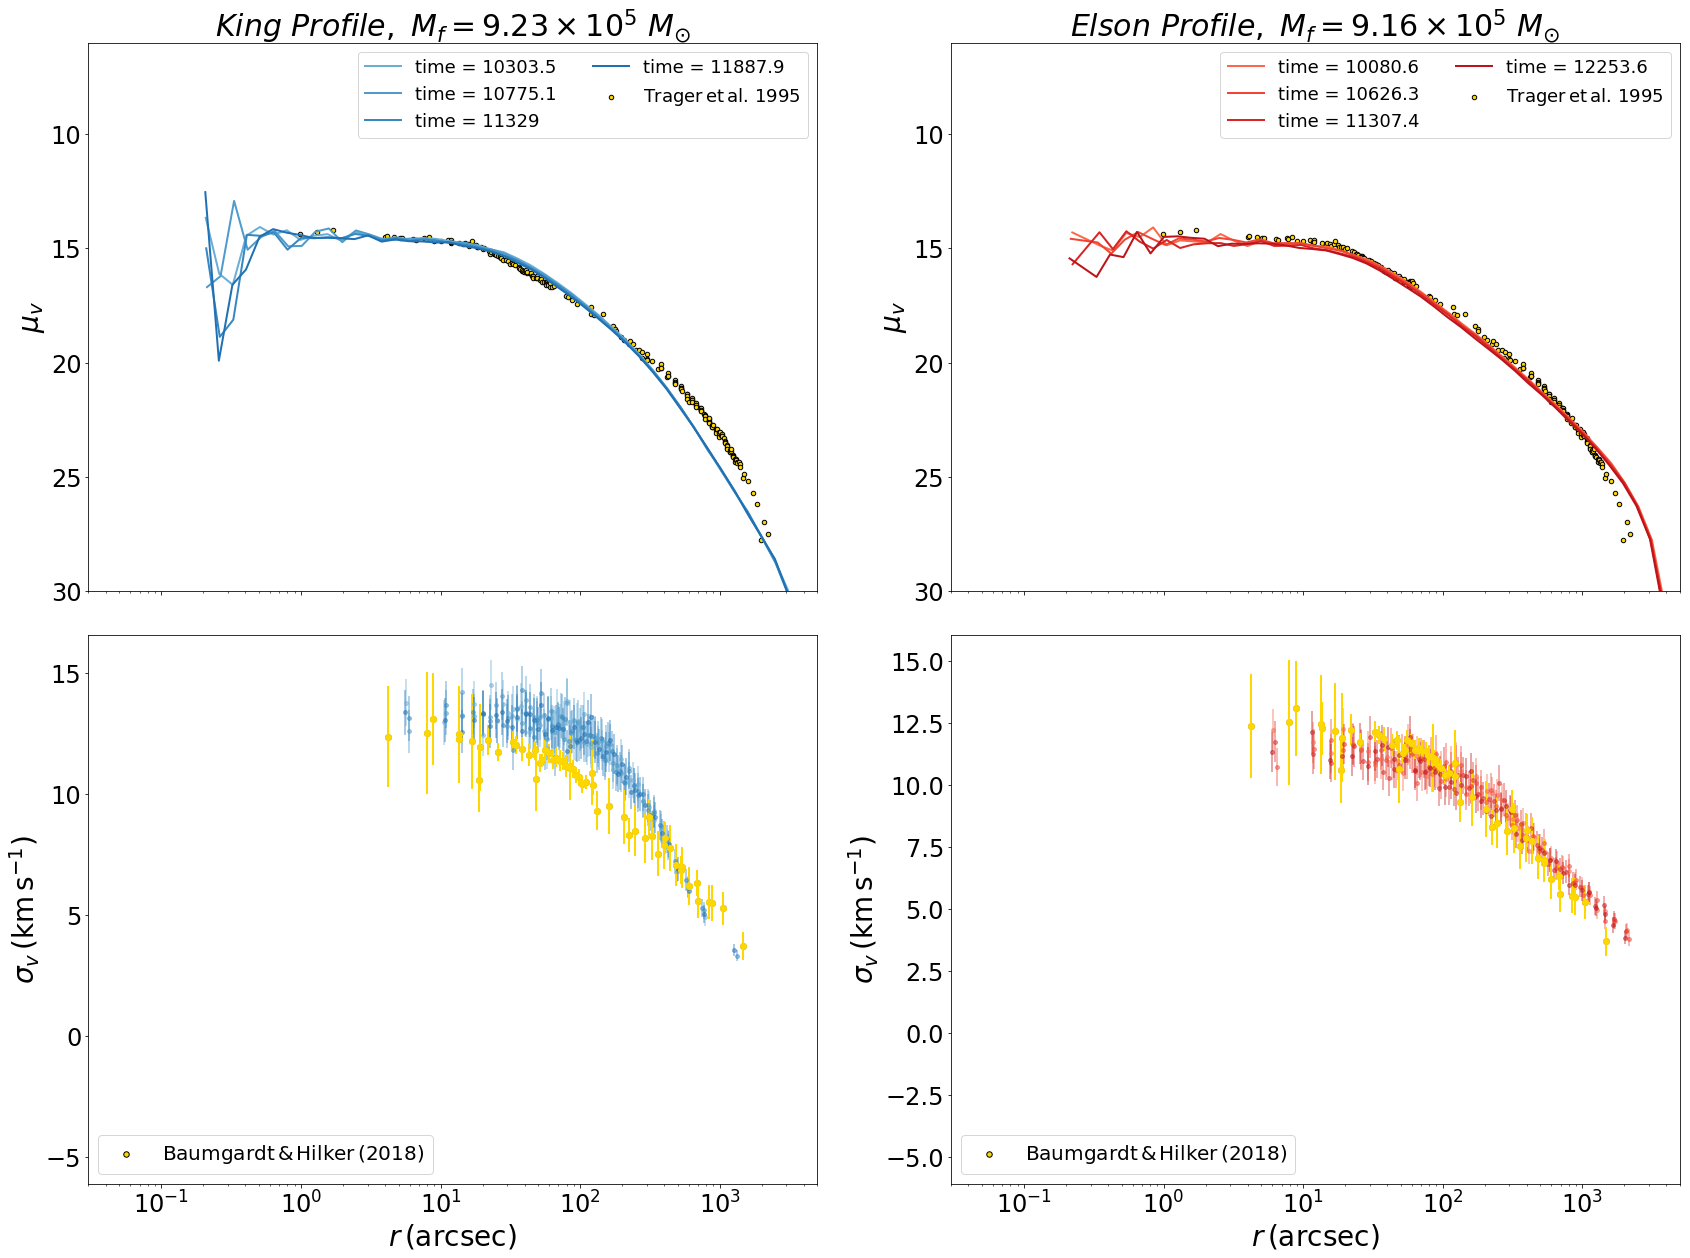

In [16]:
##Model paths: King and Elson
path=['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_150maxmass_rv1.4/', 
      '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_3e6/']


##Read in observation data
cluster = 'ngc104'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles.dat','r')
linesv = fv.readlines()

R_sun_obs=4.5


flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == cluster:
                R_obs.append(datav[k,1])
                sigma_obs.append(datav[k,2])
                sigma_err_obs_up.append(datav[k,3])
                sigma_err_obs_down.append(datav[k,4])
                flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 2, sharex=True, sharey=False, figsize=(24,18))
ax[0][0].set_title(r'$King\ Profile,\ M_f=9.23\times10^5\ M_{\odot}$', fontsize=30)
ax[0][1].set_title(r'$Elson\ Profile,\ M_f=9.16\times10^5\ M_{\odot}$', fontsize=30)
##Read in model data
for x in range(2):    
    ax[1][x].scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
    ax[1][x].errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
    ax[1][x].scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')

    ax[0][x].scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    
    snap2D = np.sort(glob(path[x]+'initial.snap*.2Dproj.dat.gz'))
    print(snap2D)
    snap2D_Ltot = np.sort(glob(path[x]+'initial.snap*.2D_SBP_NCUT.dat'))
    snap2D_L15 = np.sort(glob(path[x]+'initial.snap*.2D_SBPLcut15_NCUT.dat'))
    snap_giant = np.sort(glob(path[x]+'initial.snap*.vel_dispersion_giants_25.dat'))
    #print(snap_giant)

    cs = [cm.Blues(np.linspace(0.5, 1, len(snap2D))), cm.Reds(np.linspace(0.5, 1, len(snap2D)))]

    
    for i in range(0, len(snap2D)):
        with gzip.open(snap2D[i], 'r') as f2D:
            first_line=f2D.readline().decode('utf8')
    
        print(first_line)
            
        t_gyr = first_line.strip().split('=')[-1]
        print(t_gyr) 
        if float(t_gyr) > 12500.: continue
        data5 = np.genfromtxt(snap2D_L15[i])
        arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
        SB = conversions.SB_converter(data5[:,3])
        SBerr = data5[:,6]/data5[:,5]*SB
        SD = conversions.SD_converter(data5[:,5], R_sun_obs)
        SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
        

        arcsec_cut = []
        SB_cut = []
        SBerr_cut = []
        arcsec_nd_cut = []
        ND_cut = []
        for k in range(len(SB)):
            if arcsec[k] < 10 and SB[k] > 20:
                Nothing = 0
            else:
                arcsec_cut.append(arcsec[k])
                SB_cut.append(SB[k])
                #SBerr_cut.append(SBerr[k])
                

        dataG = np.genfromtxt(snap_giant[i])
        R_model = conversions.pc_to_arcsec(dataG[:,0],R_sun_obs)
        sigma_model = dataG[:,1]
        sigma_err_model = dataG[:,2]

        ax[0][x].plot(arcsec_cut, SB_cut, lw=2, color=cs[x][i])
        ax[1][x].scatter(R_model, sigma_model,s=15,zorder=2,alpha=0.5, color=cs[x][i])
        ax[1][x].errorbar(R_model,sigma_model,yerr=2*sigma_err_model, fmt='o',markersize=0.01,zorder=1,alpha=0.5, color=cs[x][i])
        #ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
        #ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
        #############################

        #ax1.title(cluster,fontsize=24)
        #ax1.text(300,15,cluster,fontsize=20)
        ax[0][x].plot([10000,10000],[-5,-5], lw=2, label='time = '+str(t_gyr), color=cs[x][i])
        #ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
        ax[0][x].set_xscale('log')
        ax[0][x].set_xlim(0.03,5000)
        ax[0][x].set_ylim(30,6)
        #ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
        ax[0][x].set_ylabel(r'$\mu_v$',fontsize=28)
        ax[0][x].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
        

        #ax[2][x].scatter([10000,10000],[-5,-5],lw=2,label='time = '+str(t_gyr), color=cs[i])
        #ax2.scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')
        ax[1][x].set_xscale('log')
        ax[1][x].set_xlim(0.03,5000)
        #ax2.set_ylim(0,10)
        ax[1][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
        ax[1][x].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=28)
        ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
        
        
        
fig.tight_layout()
plt.savefig('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/sbp_vel_King_Elson.pdf', dpi=300)

['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0507.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0509.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0511.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0513.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0515.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0517.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0519.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/initial.snap0521.2Dproj.dat.gz'
 '/projects/b1095/syr904/cmc/47Tuc/rundi

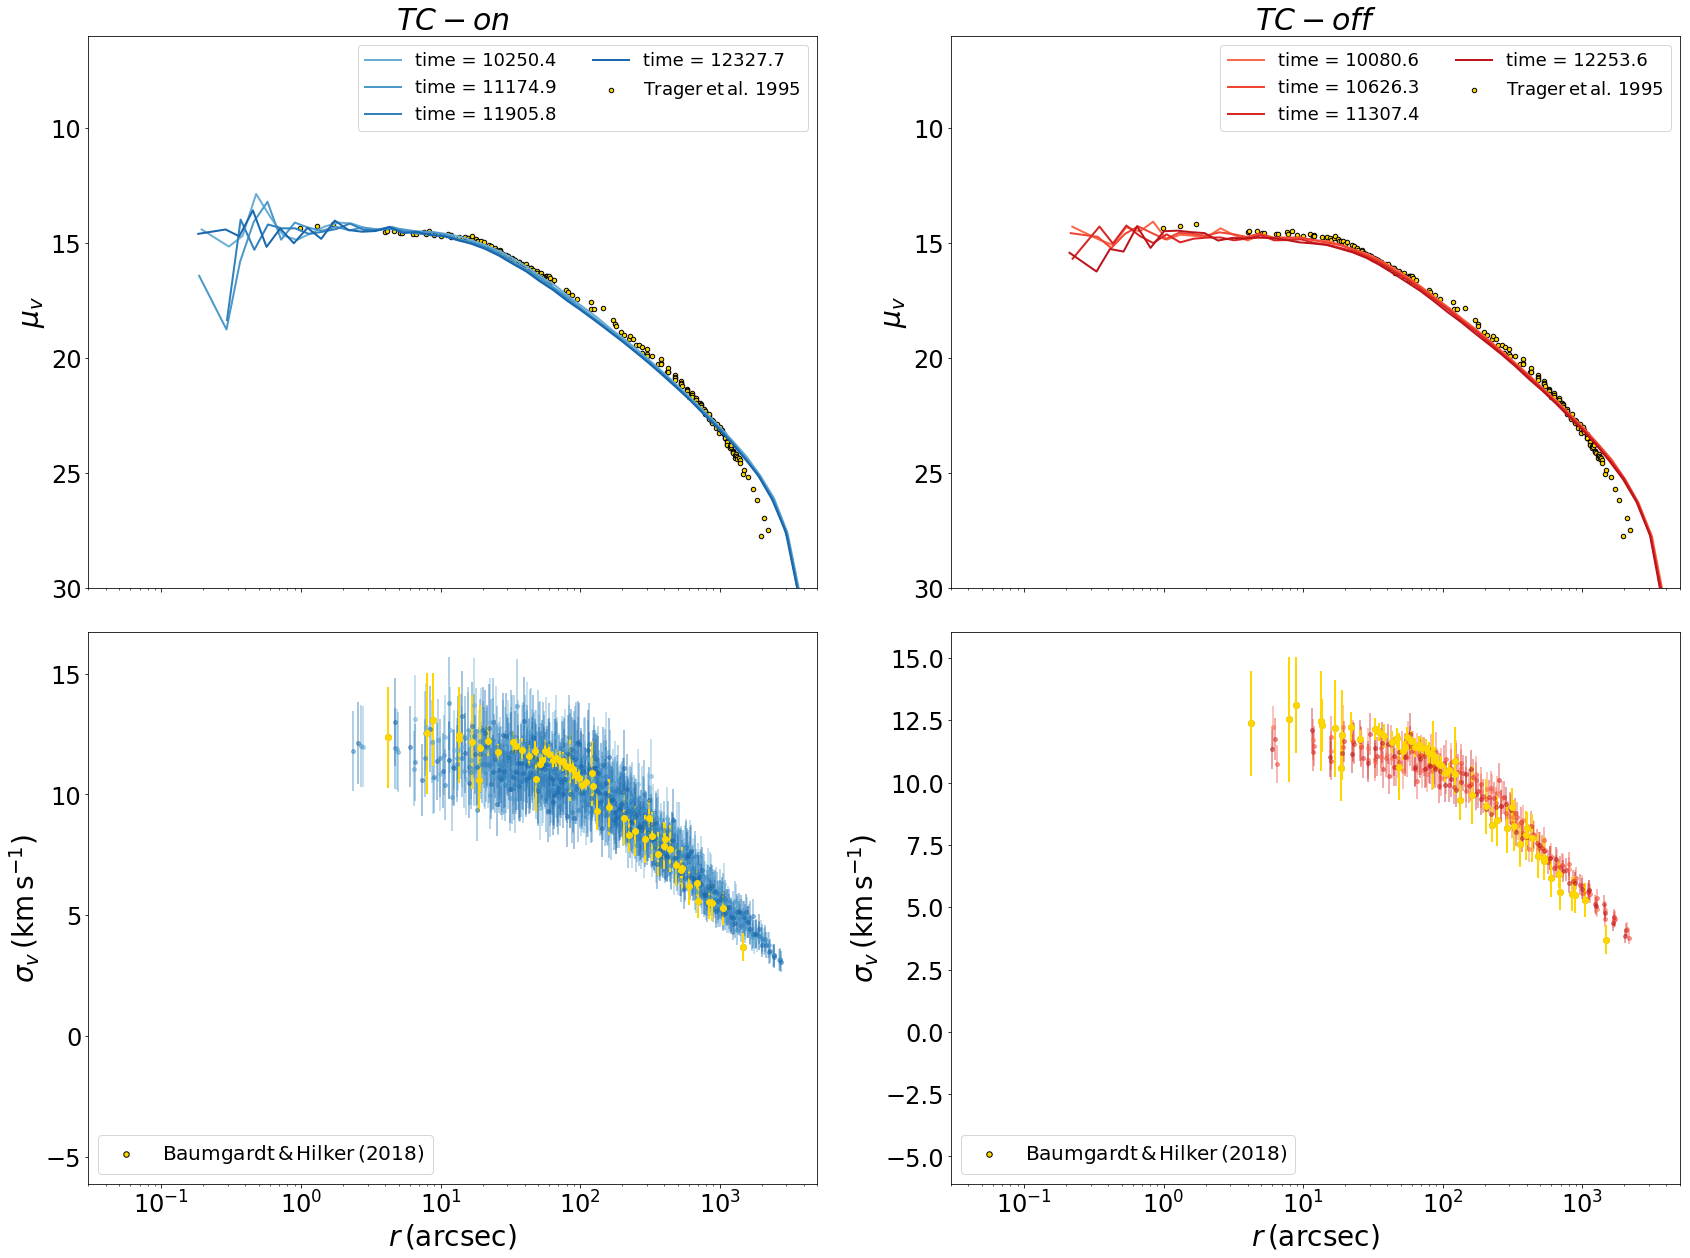

In [4]:
##Model paths: TC_on and TC_off
path=['/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/', 
      '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6/']


##Read in observation data
cluster = 'ngc104'

ft = open('makeSBP/trager.dat','r')
linest = ft.readlines()

fv = open('makeSBP/vel_dispersion_profiles.dat','r')
linesv = fv.readlines()

R_sun_obs=4.5


flag = 0
#### find observed SBP from trager file
arcsec_t = []
SB_t = []
for k in range(len(linest)):
        linet = linest[k]
        linet = linet.split('\n')
        linet = linet[0]
        linet = linet.split('\t')
        cluster_tregar = linet[1]
        if cluster_tregar == cluster:
                arcsec_t.append(np.float(linet[2]))
                SB_t.append(np.float(linet[3]))
                flag = 1
arcsec_t = np.array(arcsec_t[:])
SB_t = np.array(SB_t[:])
if flag == 0:
        print('Trager doesnt have the SBP or sigma v profile')
        sys.exit()

flag = 0
#### find observed sigma_v profile
datav = np.genfromtxt('makeSBP/vel_dispersion_profiles.dat')
R_obs = [] # in arcsec
sigma_obs = []
sigma_err_obs_up = []
sigma_err_obs_down = []
for k in range(len(linesv)):
        linev = linesv[k]
        linev = linev.split('\n')
        linev = linev[0]
        linev = linev.split(' ')
        cluster_sigma = linev[0]
        if cluster_sigma == cluster:
                R_obs.append(datav[k,1])
                sigma_obs.append(datav[k,2])
                sigma_err_obs_up.append(datav[k,3])
                sigma_err_obs_down.append(datav[k,4])
                flag = 1
R_obs = np.array(R_obs[:])
sigma_obs = np.array(sigma_obs[:])
sigma_err_obs_up = np.array(sigma_err_obs_up[:])
sigma_err_obs_down = np.array(sigma_err_obs_down[:])
############
if flag == 0:
        print('No observed sigmav profile')
        sys.exit()
        

fig, ax=plt.subplots(2, 2, sharex=True, sharey=False, figsize=(24,18))
ax[0][0].set_title(r'$TC-on$', fontsize=30)
ax[0][1].set_title(r'$TC-off$', fontsize=30)
steps = [4, 1]
##Read in model data
for x in range(2):    
    ax[1][x].scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
    ax[1][x].errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
    ax[1][x].scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')

    ax[0][x].scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
    
    snap2D = np.sort(glob(path[x]+'initial.snap*.2Dproj.dat.gz'))
    print(snap2D)
    snap2D_Ltot = np.sort(glob(path[x]+'initial.snap*.2D_SBP_NCUT.dat'))
    snap2D_L15 = np.sort(glob(path[x]+'initial.snap*.2D_SBPLcut15_NCUT.dat'))
    snap_giant = np.sort(glob(path[x]+'initial.snap*.vel_dispersion_giants_25.dat'))
    #print(snap_giant)

    cs = [cm.Blues(np.linspace(0.5, 1, len(snap2D))), cm.Reds(np.linspace(0.5, 1, len(snap2D)))]

    
    for i in range(0, len(snap2D), steps[x]):
        with gzip.open(snap2D[i], 'r') as f2D:
            first_line=f2D.readline().decode('utf8')
    
        print(first_line)
            
        t_gyr = first_line.strip().split('=')[-1]
        print(t_gyr) 
        if float(t_gyr) > 12500.: continue
        data5 = np.genfromtxt(snap2D_L15[i])
        arcsec = conversions.pc_to_arcsec(data5[:,1],R_sun_obs)
        SB = conversions.SB_converter(data5[:,3])
        SBerr = data5[:,6]/data5[:,5]*SB
        SD = conversions.SD_converter(data5[:,5], R_sun_obs)
        SDerr = conversions.SD_converter(data5[:,6], R_sun_obs)
        

        arcsec_cut = []
        SB_cut = []
        SBerr_cut = []
        arcsec_nd_cut = []
        ND_cut = []
        for k in range(len(SB)):
            if arcsec[k] < 10 and SB[k] > 20:
                Nothing = 0
            else:
                arcsec_cut.append(arcsec[k])
                SB_cut.append(SB[k])
                #SBerr_cut.append(SBerr[k])
                

        dataG = np.genfromtxt(snap_giant[i])
        R_model = conversions.pc_to_arcsec(dataG[:,0],R_sun_obs)
        sigma_model = dataG[:,1]
        sigma_err_model = dataG[:,2]

        ax[0][x].plot(arcsec_cut, SB_cut, lw=2, color=cs[x][i])
        ax[1][x].scatter(R_model, sigma_model,s=15,zorder=2,alpha=0.5, color=cs[x][i])
        ax[1][x].errorbar(R_model,sigma_model,yerr=2*sigma_err_model, fmt='o',markersize=0.01,zorder=1,alpha=0.5, color=cs[x][i])
        #ax2.scatter(R_obs, sigma_obs,c='gold',s=30, edgecolor='black')
        #ax2.errorbar(R_obs,sigma_obs,yerr=2*sigma_err_obs_up, fmt='o',c='gold', lw=2.0)
        #############################

        #ax1.title(cluster,fontsize=24)
        #ax1.text(300,15,cluster,fontsize=20)
        ax[0][x].plot([10000,10000],[-5,-5], lw=2, label='time = '+str(t_gyr), color=cs[x][i])
        #ax1.scatter(10**arcsec_t[:], SB_t[:],facecolor='gold',edgecolor='black',s=20,label=r'$\rm{Trager\,et\,al.\,1995}$')
        ax[0][x].set_xscale('log')
        ax[0][x].set_xlim(0.03,5000)
        ax[0][x].set_ylim(30,6)
        #ax[0][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=20)
        ax[0][x].set_ylabel(r'$\mu_v$',fontsize=28)
        ax[0][x].legend(loc='best',scatterpoints=1, ncol=2, prop={'size': 18})
        

        #ax[2][x].scatter([10000,10000],[-5,-5],lw=2,label='time = '+str(t_gyr), color=cs[i])
        #ax2.scatter([10000,10000],[-5,-5],c='gold',s=30, edgecolor='black',label=r'$\rm{Baumgardt\,&\,Hilker\,(2018)}$')
        ax[1][x].set_xscale('log')
        ax[1][x].set_xlim(0.03,5000)
        #ax2.set_ylim(0,10)
        ax[1][x].set_xlabel(r'$r\,(\rm{arcsec})$',fontsize=28)
        ax[1][x].set_ylabel(r'$\sigma_v\,(\rm{km\,s^{-1}})$',fontsize=28)
        ax[1][x].legend(loc=3,scatterpoints=1, ncol=2, prop={'size': 20})
        
        
        
fig.tight_layout()
#plt.savefig('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc_size/sbp_vel_King_Elson.pdf', dpi=300)

[1.4836016225343536, 1.430414002982872, 1.4429282911244696, 1.146632383152948, 1.4632668553385768, 1.0625178481603028, 0.9608773983290091, 0.9856825453203206, 1.1120650633472935, 0.8322812860794616, 0.8420452108626686, 1.0866680105778996, 0.7513767108266808, 0.6868410483271276, 0.5766033679229189, 0.4774957286245386, 0.49564033166874577, 0.299364150869206, 0.25658716299597983, 0.0032163177474249867] [-0.8548854620896111, -0.6248847989700257, -0.7680383374164585, 0.08855970502190119, 1.1438021670769796, 0.8943648329265308, 0.6723585875636743, -0.7696189819518883, 1.0388554088979227, -0.3036722462683614, -0.48194109060100926, -1.039385319313314, -0.34736477755764184, 0.024095489973416803, 0.1203208366154833, -0.27276193362317164, 0.41164997929500297, 0.14294461847545537, 0.25805195837785044, -0.002322605894549987]


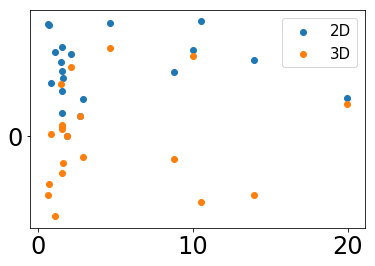

In [2]:
##Compare 2d and 3d accelerations
dataacc=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_3e6/msp_accel_last.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_3e6/msp_last.dat')

model=dataacc[:,0]; id0=dataacc[:,1]; id1=dataacc[:,2]
r2d=dataacc[:,5]; Mr2d=dataacc[:,7]
r3d=dataacc[:,6]; Mr3d=dataacc[:,8]
vz=dataacc[:,14]
rx=dataacc[:,9]; ry=dataacc[:,10]; rz=dataacc[:,11]

A=datapsr[:,17]; ecc=datapsr[:,18]; M0=datapsr[:,13]; M1=datapsr[:,14]; P=datapsr[:,5]; B=datapsr[:,4]
Pdot=Kconst*yearsc*np.array(B)*np.array(B)/np.array(P)

MAXAL_2D = []; MAXAL_3D = []; P_2D = []; P_3D = []
for i in range(len(id0)):
    maxal_2d, pdotmin_2d, pdotmax_2d, p_2d = ns.add_acceleration_GCpotential_max(r2d[i], vz[i], Pdot[i], P[i], Mr2d[i])
    maxal_3d, pdotmin_3d, pdotmax_3d, p_3d = ns.add_acceleration_GCpotential_3D(r3d[i], vz[i], Pdot[i], P[i], Mr3d[i], rx[i], ry[i], rz[i])
    MAXAL_2D.append(maxal_2d*10**6); MAXAL_3D.append(maxal_3d*10**6)
    P_2D.append(p_2d*1000); P_3D.append(p_3d*1000)
    
print(MAXAL_2D, MAXAL_3D)
plt.figure()
plt.scatter(P_2D, MAXAL_2D, label = '2D')
plt.scatter(P_3D, MAXAL_3D, label = '3D')
plt.yscale('symlog')
plt.legend(loc='best', fontsize=15)


In [8]:
##Line-of-acceleration profile
##Calculae isolated pulsar maximum line-of-sight acceleration
data_sin_psr = np.genfromtxt('/projects/b1095/syr904/projects/massive_clusters/47Tuc_isolated_psr.dat')

##The difference between the accelerations of the Solar system and 47 Tuc.
a = -1.172*10**(-10) ## m/s^−2
d = 4.69  ##kpc

for i in range(9):
    A = data_sin_psr[:,2][i]*10**(-21)/(data_sin_psr[:,1][i]*1000)*(clight/100.)
    B = (data_sin_psr[:,3][i]**2+data_sin_psr[:,4][i]**2)*(d*PC/100.)
    C = a


[      nan   5.75678 -49.85      5.2      -3.1       1.2298 ]


[]


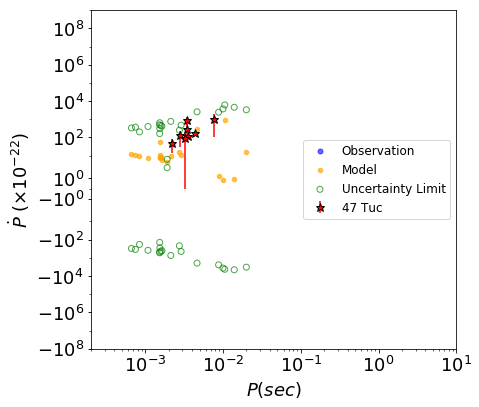

In [4]:
##P-Pdot plot
###Plot B-P of MSPs from models on top of observed data###

##Data from 47 Tuc and Terzan 5
data47tuc=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/data/47tuc_pulsars.dat')
datater5=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/data/Terzan5_pulsars.dat')
P47=np.array(data47tuc[:,1]); Pdot47=np.array(data47tuc[:,2]); Pdoterr47=np.array(data47tuc[:,3])
P5=np.array(datater5[:,2]); Pdot5=np.array(datater5[:,3])

###Model Data###
datamsp=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_3e6/msp_last.dat')
#datapsr=np.genfromtxt('/projects/b1095/syr904/projects/PULSAR2/newruns/finaldata/normalpsr_maingrid_last.dat')


B=np.array(datamsp[:,4]); P=np.array(datamsp[:,5])
#Bpsr=np.array(datapsr[:,4]); Ppsr=np.array(datapsr[:,5])

Pdot=Kconst*yearsc*B*B/P
#Pdotpsr=Kconst*yearsc*Bpsr*Bpsr/Ppsr
#print Pdot/P, Pdotpsr/Ppsr


###Observational Data###
Ps, Pb, Pdots, Pdotb, Period, Ecc=ns.readdata_freire() #P in ms, B in G
Ps, Pb, Pdots, Pdotb=np.array(Ps), np.array(Pb), np.array(Pdots), np.array(Pdotb)
print(Ps)
#print Pdots, Pdotb


###Acceleration for the model data### 
dpdotm, dpdotp, pdotlow, pdotup, pmod=ns.get_acceleration('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_3e6/msp_accel_last.dat',
                                                          '/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/MOCHA47Tuc_elson_rv4_3e6/msp_last.dat')
#dpdotm_psr, dpdotp_psr, pdotlow_psr, pdotup_psr, ppsrmod=ns.get_acceleration('/projects/b1095/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/data/kickgrid_accl_normalpsr_newmodel.dat',
#                                                                             '/projects/b1095/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/data/kickgrid_normalpsr_newmodel.dat')

dpdotm, dpdotp, pdotlow, pdotup=np.array(dpdotm), np.array(dpdotp), np.array(pdotlow), np.array(pdotup)
#dpdotm_psr, dpdotp_psr, pdotlow_psr, pdotup_psr=np.array(dpdotm_psr), np.array(dpdotp_psr), np.array(pdotlow_psr), np.array(pdotup_psr)


###Scaling###
Pdots=Pdots*10**19*1000; Pdotb=Pdotb*10**19*1000
Pdot=Pdot*10**19*1000#; Pdotpsr=Pdotpsr*10**19*1000
pdotlow=pdotlow*10**19*1000; pdotup=pdotup*10**19*1000
#pdotlow_psr=pdotlow_psr*10**19*1000; pdotup_psr=pdotup_psr*10**19*1000

#Death Line
x=np.logspace(-2.0, 2.0, num=50)

matplotlib.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [7, 6]

plt.figure()

##########################
plt.scatter(Ps*0.001, Pdots, c='b', alpha=0.6, s=25, label='Observation')
plt.scatter(Pb*0.001, Pdotb, c='b', alpha=0.6, s=25)
#plt.plot(x, (x**2)*(0.17*10**12), 'k--')    #Deadthline
##########################
plt.scatter(P, Pdot, color='orange', alpha=0.7, s=20, label='Model')
plt.scatter(pmod, pdotlow, color='green', alpha=0.7, facecolor='none', label='Uncertainty Limit')
plt.scatter(pmod, pdotup, color='green', alpha=0.7, facecolor='none')
##########################
plt.errorbar(P47*0.001, Pdot47*10., yerr=Pdoterr47*10., fmt='*', color='red', ms=9, markeredgecolor='k',label='47 Tuc')
#plt.scatter(P5*0.001, Pdot5*10, marker='^', color='red', s=25, edgecolor='k', label='Terzan 5')
##########################
#plt.scatter(Ppsr, Pdotpsr, color='orange', alpha=0.7)
#plt.scatter(ppsrmod, pdotlow_psr, color='green', alpha=0.7, facecolor='none')
#plt.scatter(ppsrmod, pdotup_psr, color='green', alpha=0.7, facecolor='none')
###
#plt.hline(y=0)
###
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel(r'$P(sec)$')
plt.ylabel(r'$\dot{P}\ (\times 10^{-22})$')
plt.ylim(-100000000, 1000000000)
plt.xlim(0.0002, 10.)
#ax.yaxis.set_major_locator(plt.MaxNLocator(3))
#plt.locator_params(nbins=10)
yticks = plt.gca().yaxis.get_major_ticks()
yticks[5].set_visible(False)
plt.locator_params(numticks=10)
plt.tight_layout()
plt.legend(loc='center right', scatterpoints=1, numpoints=1, prop={'size': 12})
#plt.savefig('/projects/b1011/syr904/projects/PULSAR/kickgrid_runs/MSPBHinGC/plots/ppdot_47tucter5.pdf', dpi=300)

[2.25684 2.3577 0.22979 0.12066 0.13597 0.14725 1.18908 0.06623 1.20172
 1.12618 0.42911 0.21213 0.133 10.9212 0.52194 0.1793 0.3184] [0.18 0.19 0.015 0.024 0.025 0.02 0.21 0.03 0.1 0.2 0.14 0.35 0.14 0.42
 0.16 0.0089 0.235]
5
[array([0.005689]), array([0.005713]), array([0.005717]), array([0.005732]), array([0.005741]), array([0.005824]), array([0.005835]), array([0.005843]), array([0.005851]), array([0.005854]), array([0.005867]), array([0.00588]), array([0.005881]), array([0.005907]), array([0.005913]), array([0.005922]), array([0.00593]), array([0.005932]), array([0.005939]), array([0.00594]), array([0.005966]), array([0.005981]), array([0.006023]), array([0.006025]), array([0.006085]), array([0.006193]), array([0.006216]), array([0.006219]), array([0.00628]), array([0.006453]), array([0.006595]), array([0.007399]), array([0.007511]), array([0.007759]), array([0.008433]), array([0.0096]), array([0.009981]), array([0.011487]), array([0.013325]), array([0.014285]), array([0.306487])

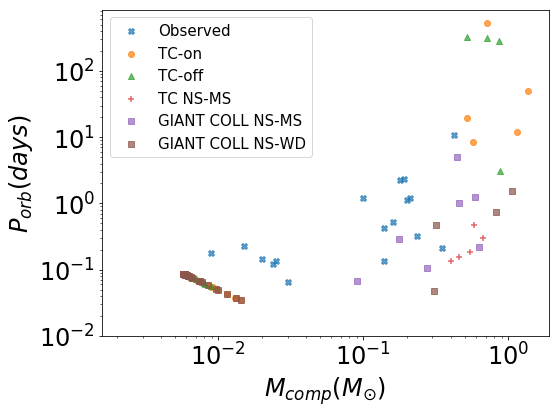

In [2]:
##Pulsars at last snapshot with tidal capture turned on and off
##Observed pulsars
df_obs_psr = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/47tuc_pulsars.xlsx', 
                        skiprows = 1, 
                        names = ['Name', 'Offset', 'Periods', 'Pdot', 'DM', 'Pb', 'X', 'Ecc', 'Mcomp'])
pb_47tuc = np.array(df_obs_psr['Pb']); mc_47tuc = np.array(df_obs_psr['Mcomp'])
index_i = np.argwhere(pb_47tuc == 'i')
pb_47tuc = np.delete(pb_47tuc, index_i); mc_47tuc = np.delete(mc_47tuc, index_i)
print(pb_47tuc, mc_47tuc)

##TC-ON pulsars
msp_elson_tcon = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/msp_last.dat')
sma_tcon = msp_elson_tcon[:,16]; mc_tcon = msp_elson_tcon[:,11]; mns_tcon = msp_elson_tcon[:,10]
index_100 = np.argwhere(mc_tcon == -100.)
sma_tcon = np.delete(sma_tcon, index_100)
mc_tcon = np.delete(mc_tcon, index_100); mns_tcon = np.delete(mns_tcon, index_100)
pb_tcon = [uc.au_to_period(sma_tcon[i], mns_tcon[i], mc_tcon[i]) for i in range(len(sma_tcon))]


##TC-OFF pulsars
msp_elson_tcoff = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6/msp_last.dat')
sma_tcoff = msp_elson_tcoff[:,17]; mc_tcoff = msp_elson_tcoff[:,14]; mns_tcoff = msp_elson_tcoff[:,13]
index_100 = np.argwhere(mc_tcoff == -100.)
sma_tcoff = np.delete(sma_tcoff, index_100)
mc_tcoff = np.delete(mc_tcoff, index_100); mns_tcoff = np.delete(mns_tcoff, index_100)
pb_tcoff = [uc.au_to_period(sma_tcoff[i], mns_tcoff[i], mc_tcoff[i]) for i in range(len(sma_tcoff))]


##TC NS-MS binaries and collision
nsms_tc = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSMS_last.dat')
mns_nsms = nsms_tc[:,4]; mms_nsms = nsms_tc[:,5]; sma_nsms = nsms_tc[:,8]
tcflag = nsms_tc[:,14]
pb_nsms = [uc.au_to_period(sma_nsms[i], mns_nsms[i], mms_nsms[i]) for i in range(len(sma_nsms))]
index_91 = np.argwhere(tcflag == 91)
index_81 = np.argwhere(tcflag == 81)
mms_nsms_91 = np.take(mms_nsms, index_91); pb_nsms_91 = np.take(pb_nsms, index_91)
print(len(mms_nsms_91))
mms_nsms_81 = np.take(mms_nsms, index_81); pb_nsms_81 = np.take(pb_nsms, index_81)

##TC NS-MS binaries and collision
nswd_tc = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD_last.dat')
mns_nswd = nswd_tc[:,4]; mms_nswd = nswd_tc[:,5]; sma_nswd = nswd_tc[:,8]
tcflag_wd = nswd_tc[:,14]
pb_nswd = [uc.au_to_period(sma_nswd[i], mns_nswd[i], mms_nswd[i]) for i in range(len(sma_nswd))]
index_91_wd = np.argwhere(tcflag_wd == 91)
index_81_wd = np.argwhere(tcflag_wd == 81)
mms_nswd_91 = np.take(mms_nswd, index_91_wd); pb_nswd_91 = np.take(pb_nswd, index_91_wd)
mms_nswd_81 = np.take(mms_nswd, index_81_wd); pb_nswd_81 = np.take(pb_nswd, index_81_wd)
mms_sort = sorted(mms_nswd_81)
print(mms_sort)


#print(pb_tcon, mc_tcon)
#print(pb_tcoff, mc_tcoff)
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(mc_47tuc, pb_47tuc, marker = 'X', alpha = 0.7, label = 'Observed')
ax.scatter(mc_tcon, pb_tcon, alpha = 0.7, label = 'TC-on')
ax.scatter(mc_tcoff, pb_tcoff, marker = '^', alpha = 0.7, label = 'TC-off')
ax.scatter(mms_nsms_91, pb_nsms_91, marker = '+', label = 'TC NS-MS', alpha = 0.7,)
ax.scatter(mms_nsms_81, pb_nsms_81, marker = 's', label = 'GIANT COLL NS-MS', alpha = 0.7,)
#ax.scatter(mms_nswd_91, pb_nswd_91, marker = '+', label = 'TC NS-WD')
ax.scatter(mms_nswd_81, pb_nswd_81, marker = 's', label = 'GIANT COLL NS-WD', alpha = 0.7,)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$P_{orb}(days)$')
ax.set_xlabel(r'$M_{comp}(M_{\odot})$')
ax.set_ylim(ymin = 0.01)
ax.legend(loc = 'best', fontsize=15)

[2.25684 2.3577 0.22979 0.12066 0.13597 0.14725 1.18908 0.06623 1.20172
 1.12618 0.42911 0.21213 0.133 10.9212 0.52194 0.1793 0.3184] [0.18 0.19 0.015 0.024 0.025 0.02 0.21 0.03 0.1 0.2 0.14 0.35 0.14 0.42
 0.16 0.0089 0.235]


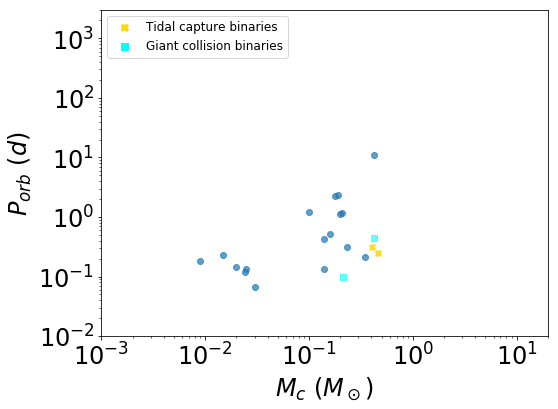

In [9]:
##Compare model pulsars Mc_Period with observed ones
##for tidal capture and giant collision binaries between 9-12 Gyr

###Get model data
##Pulsars at the last timestep
datamsp=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/msp_last.dat')
datapsr=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/normalpsr_last.dat')
m0_msp=datamsp[:,10]; m1_msp=datamsp[:,11]; sma_msp=datamsp[:,16]; ecc_msp=datamsp[:,17]
k0_msp=datamsp[:,14]; k1_msp=datamsp[:,15]; B_msp=datamsp[:,4]; P_msp=datamsp[:,5]
id0_msp=datamsp[:,12]; id1_msp=datamsp[:,13]; model_msp=datamsp[:,0]

m0_psr=datapsr[:,10]; m1_psr=datapsr[:,11]; sma_psr=datapsr[:,16]; ecc_psr=datapsr[:,17]
k0_psr=datapsr[:,14]; k1_psr=datapsr[:,15]; B_psr=datapsr[:,4]; P_psr=datapsr[:,5]
id0_psr=datapsr[:,12]; id1_psr=datapsr[:,13]; model_psr=datapsr[:,0]

Pdot_psr=Kconst*yearsc*B_psr*B_psr/P_psr
Pdot_msp=Kconst*yearsc*B_msp*B_msp/P_msp
Pdot_msp=Pdot_msp *10**19*1000; Pdot_psr=Pdot_psr*10**19*1000
P_msp = P_msp*1000; P_psr = P_psr*1000


##Create distinc ids for different models
id0_new_psr = []
for x in range(len(model_psr)):
    id0_new_psr.append(str(int(model_psr[x]))+str(int(id0_psr[x])))
    
id0_new_msp = []
for y in range(len(model_msp)):
    id0_new_msp.append(str(int(model_msp[y]))+str(int(id0_msp[y])))



##NSWD and NSMS binaries that are not MSPs or young pulsars at the last timestep
data13ms=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSMS_last.dat')
data13wd=np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/NSWD_last.dat')

id0_13ms=data13ms[:,2]; id1_13ms=data13ms[:,3]; m0_13ms=data13ms[:,4]; m1_13ms=data13ms[:,5]
sma_13ms=data13ms[:,8]; ecc_13ms=data13ms[:,9]; tcflag_13ms=data13ms[:,14]
model_13ms=data13ms[:,0]
k0_13ms=data13ms[:,6]; k1_13ms=data13ms[:,7]

id0_13wd=data13wd[:,2]; id1_13wd=data13wd[:,3]; m0_13wd=data13wd[:,4]; m1_13wd=data13wd[:,5]
sma_13wd=data13wd[:,8]; ecc_13wd=data13wd[:,9]; tcflag_13wd=data13wd[:,14]
model_13wd=data13wd[:,0]
k0_13wd=data13wd[:,6]; k1_13wd=data13wd[:,7]

##Create distinct ids for different models
id0_new_13ms = []
for x in range(len(model_13ms)):
    id0_new_13ms.append(str(int(model_13ms[x]))+str(int(id0_13ms[x])))
    
id0_new_13wd = []
for y in range(len(model_13wd)):
    id0_new_13wd.append(str(int(model_13wd[y]))+str(int(id0_13wd[y])))


##Tidal capture and giant collision binaries at all times
datatc = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/all_tc_NSXX.dat')
datacoll = np.genfromtxt('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/best_fits/MOCHA47Tuc_elson_rv4_3e6_tcon/all_coll_NSXX.dat')
time_tc = datatc[:,1]; m0_tc = datatc[:,14]; m1_tc = datatc[:,15]; pb_tc = datatc[:,18]
time_coll = datacoll[:,1]; m0_coll = datacoll[:,14]; m1_coll = datacoll[:,15]
pb_coll = datacoll[:,18]; k1_coll = datacoll[:,13]

m1_tc_912 = []; pb_tc_912 = []
m1_coll_912 = []; pb_coll_912 = []
m1_coll_912_ms = []; pb_coll_912_ms = []
m1_coll_912_hems = []; pb_coll_912_hems = []
m1_coll_912_hewd = []; pb_coll_912_hewd = []
m1_coll_912_other = []; pb_coll_912_other = []
for x in range(len(time_tc)):
    if 9000.<=time_tc[x]<=13000.:
        m1_tc_912.append(m1_tc[x]); pb_tc_912.append(pb_tc[x])

for y in range(len(time_coll)):
    if 9000.<=time_coll[y]<=13000.:
        m1_coll_912.append(m1_coll[y]); pb_coll_912.append(pb_coll[y])
        if k1_coll[y] <= 1:
            m1_coll_912_ms.append(m1_coll[y]); pb_coll_912_ms.append(pb_coll[y])
        elif k1_coll[y] == 7:
            m1_coll_912_hems.append(m1_coll[y]); pb_coll_912_hems.append(pb_coll[y])
        elif k1_coll[y] == 10:
            m1_coll_912_hewd.append(m1_coll[y]); pb_coll_912_hewd.append(pb_coll[y])
        else:
            m1_coll_912_other.append(m1_coll[y]); pb_coll_912_other.append(pb_coll[y])

                                        
###Get observed data
df_obs_psr = pd.read_excel('/projects/b1095/syr904/cmc/47Tuc/rundir/47Tuc/47tuc_pulsars.xlsx', 
                        skiprows = 1, 
                        names = ['Name', 'Offset', 'Periods', 'Pdot', 'DM', 'Pb', 'X', 'Ecc', 'Mcomp'])
pb_47tuc = np.array(df_obs_psr['Pb']); mc_47tuc = np.array(df_obs_psr['Mcomp'])
index_i = np.argwhere(pb_47tuc == 'i')
pb_47tuc = np.delete(pb_47tuc, index_i); mc_47tuc = np.delete(mc_47tuc, index_i)
print(pb_47tuc, mc_47tuc)

###Plotting
plt.rcParams['figure.figsize'] = [8,6]
rdot=mlines.Line2D([], [],  linestyle = 'None', color='r', marker='o',
                  markersize=7, label='Redbacks')
kdot=mlines.Line2D([], [],  linestyle = 'None', color='k', marker='o',
                  markersize=7, label='Black widows')
bdot=mlines.Line2D([], [],  linestyle = 'None', color='b', marker='o',
                  markersize=7, label='Others')
gtri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')
cross=mlines.Line2D([], [],  linestyle = 'None', color='gold', marker='X',
                  markersize=7, label='Tidal capture binaries')
square=mlines.Line2D([], [],  linestyle = 'None', color='aqua', marker='s',
                  markersize=7, label='Giant collision binaries')
tri=mlines.Line2D([], [],  linestyle = 'None', color='g', marker='^',
                  markersize=7, label='Others')


fig, axs = plt.subplots(nrows=1, sharey=False)
            
##Observed data
axs.scatter(mc_47tuc, pb_47tuc, alpha = 0.7, label = 'Observed')        

axs.scatter(m1_tc_912, pb_tc_912, marker = 'X', color = 'gold', alpha=0.8)
#axs.scatter(m1_coll_912, pb_coll_912, label = 'GIANT COLL BINARIES')
axs.scatter(m1_coll_912_ms, pb_coll_912_ms, marker = 's', color = 'gold', alpha=0.8)
axs.scatter(m1_coll_912_hems, pb_coll_912_hems, marker = 's', color = 'green', alpha=0.6)
axs.scatter(m1_coll_912_hewd, pb_coll_912_hewd, marker = 's', color = 'aqua', alpha=0.6)
axs.scatter(m1_coll_912_other, pb_coll_912_other, marker = 's', color = 'violet', alpha=0.6)
        
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_ylim(0.01, 3000)
axs.set_xlim(0.001, 20)
axs.set_xlabel(r'$M_c\ (M_\odot)$')
axs.set_ylabel(r'$P_{orb}\ (d)$')
axs.legend(handles=[cross, square], loc='upper left', prop={'size': 12}, numpoints=1, frameon=True)